C:\Users\pavel\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\pavel\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

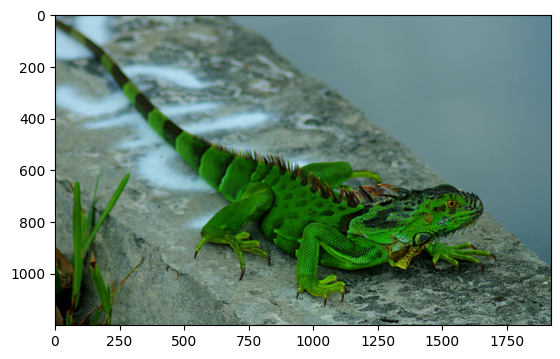

In [1]:
import torch
import numpy as np
import torchvision
import onnx
from torchvision.models import *
from torchvision.models.quantization import *
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
import onnxruntime as ort
import cv2
import onnxruntime as ort
from onnx_tf.backend import prepare
import tensorflow as tf
from ultralytics import YOLO
#import coremltools as ct
!curl https://w.forfun.com/fetch/dd/dd265d02e46301b5db41c56f72b460e8.jpeg -o test.jpg
way="test.jpg"
img = cv2.imread(way)
plt.imshow(plt.imread(way))#рисование картинки

In [2]:
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
    t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
    t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
    t = t.permute(2,0,1) # hwc -> chw
    _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
    _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
    t = (t - _m) / (_s + 1E-7)
    return t
tensor_img1 = img2tensor(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
print(tensor_img1.shape)

torch.Size([1, 3, 224, 224])


# torch

In [3]:
model = torchvision.models.mnasnet1_0(weights=MNASNet1_0_Weights.IMAGENET1K_V1)
model.eval()

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [4]:
with torch.no_grad():tensor_img1_out = model(tensor_img1)
#print(tensor_img1_out)

In [5]:
out_probs = torch.nn.functional.softmax(tensor_img1_out[0], dim = 0)
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -o imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:categories = [s.strip() for s in f.readlines()]
prob, category_id = torch.topk(out_probs, 5)
for i in range(prob.size(0)):
    print(categories[category_id[i]], prob[i].item())

green lizard 0.5757102370262146
common iguana 0.4147088825702667
American chameleon 0.003233993658795953
scorpion 0.002432889072224498
banded gecko 0.0012056026607751846


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10472  100 10472    0     0  23206      0 --:--:-- --:--:-- --:--:-- 23322


# onnx

In [6]:
dummy_input = torch.randn(1, 3, 224, 224)
input_names = [ "img_input" ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "mnasnet1_0.onnx", verbose=True, input_names=input_names, output_names=output_names)
# Load the ONNX model
model_onnx = onnx.load("mnasnet1_0.onnx")
onnx.checker.check_model(model_onnx)
#print(onnx.helper.printable_graph(model_onnx.graph))

In [7]:
ort_session = ort.InferenceSession("mnasnet1_0.onnx",providers=['CPUExecutionProvider'])
model_input_name = ort_session.get_inputs()[0].name
model_output_name = ort_session.get_outputs()[0].name

x = img2tensor(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0).numpy()

out = ort_session.run(
    [model_output_name],
    {model_input_name: x}
)

In [8]:
out_probs_onnx = torch.nn.functional.softmax(torch.from_numpy(out[0])[0], dim = 0)
# show top 5 founded categories
prob, category_id = torch.topk(out_probs_onnx, 5)
for i in range(prob.size(0)):
    print(categories[category_id[i]], prob[i].item())

green lizard 0.5757097601890564
common iguana 0.41470932960510254
American chameleon 0.0032339938916265965
scorpion 0.002432870678603649
banded gecko 0.0012056005652993917


 # ONNX to TF

In [9]:
tf_rep = prepare(model_onnx)
tf_rep.export_graph("mnasnet1_0tf")

INFO:tensorflow:Assets written to: mnasnet1_0tf\assets


INFO:tensorflow:Assets written to: mnasnet1_0tf\assets


# TF to TFLite

In [10]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("mnasnet1_0tf")
tflite_model = converter.convert()

# Save the model
with open("mnasnet1_0tf-lite", 'wb') as f:
    f.write(tflite_model)

In [11]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="mnasnet1_0tf-lite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_data = np.array(tensor_img1)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)

In [12]:
out_probs_tflite = torch.nn.functional.softmax(torch.from_numpy(output_data)[0], dim = 0)

In [13]:
# show top 5 founded categories
prob, category_id = torch.topk(out_probs_tflite, 5)
for i in range(prob.size(0)):
  print(categories[category_id[i]], prob[i].item())

green lizard 0.5757083892822266
common iguana 0.4147107005119324
American chameleon 0.0032340080942958593
scorpion 0.002432843903079629
banded gecko 0.001205597654916346


# YOLOv5

PRO TIP  Replace 'model=yolov5l.pt' with new 'model=yolov5lu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 416x640 1 bird, 598.6ms
Speed: 5.0ms preprocess, 598.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


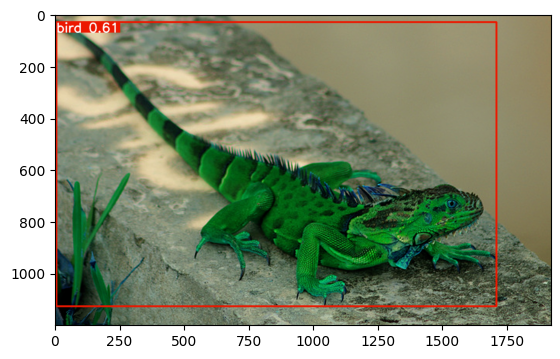

In [14]:
model_yolo = YOLO('yolov5l.pt')
yolo_res = model_yolo(['test.jpg'])
yolo_res = yolo_res[0].cpu()

detection_visualization = yolo_res.plot()
plt.imshow(detection_visualization)


0: 416x640 (no detections), 85.0ms
Speed: 4.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


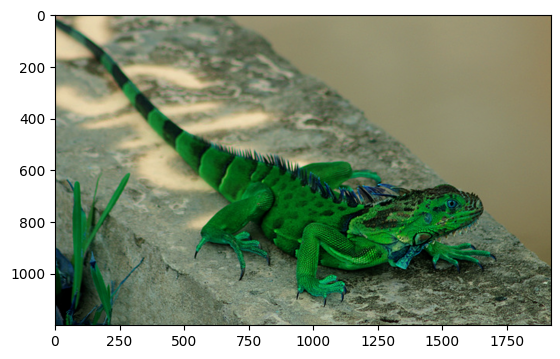

In [15]:
model_yolo = YOLO('yolov8n.pt')
yolo_res = model_yolo(['test.jpg'])
yolo_res = yolo_res[0].cpu()

detection_visualization = yolo_res.plot()
plt.imshow(detection_visualization)


0: 416x640 1 bird, 175.5ms
Speed: 3.0ms preprocess, 175.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


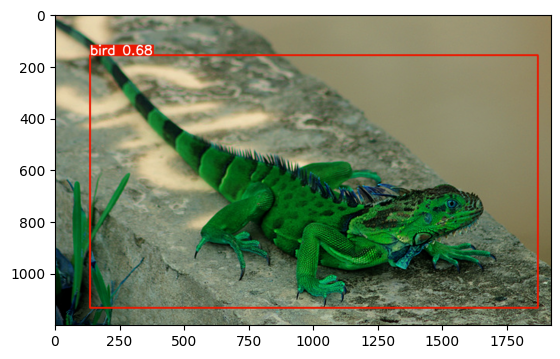

In [16]:
model_yolo = YOLO('yolov8s.pt')
yolo_res = model_yolo(['test.jpg'])
yolo_res = yolo_res[0].cpu()

detection_visualization = yolo_res.plot()
plt.imshow(detection_visualization)

In [ ]:

import webbrowser
webbrowser.open_new('https://colab.research.google.com/drive/1qZomJqqTlIoqPh4UjLaqU2PFvZPitudv?authuser=0#scrollTo=8B3biETQeIpB')


In [20]:
!yolo export model=./content/yolov8s.pt format=tflite


Ultralytics YOLOv8.0.195  Python-3.10.9 torch-2.1.0+cpu CPU (Intel Core(TM) i7-8650U 1.90GHz)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

PyTorch: starting from 'content\yolov8s.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx_graphsurgeon>=0.3.26', 'tflite_support'] not found, attempting AutoUpdate...
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [84 lines of output]
  C:\Users\pavel\anaconda3\lib\site-packages\setuptools\__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          **********************************

True